In [1]:
# from comet_ml import Experiment
# experiment = Experiment(api_key="xktj4EX0zB8YcQ3BEaFwOQYpu")

In [2]:
import numpy as np
from keras.models import Sequential 
from keras.layers import Dense, Activation
from keras.regularizers import l2
from keras.utils import np_utils 

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [30]:
import os
import fnmatch

import pandas as pd

import sklearn.preprocessing as preprocessing
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

import itertools

import scipy.stats as stats

## Load Data

In [4]:
train_path = "I:\\Honours-Project\\data\\sorted\\agg\\train\\"
train_csv = "I:\\Honours-Project\\data\\sorted\\agg\\train\\ids.csv"
test_path = "I:\\Honours-Project\\data\\sorted\\agg\\test\\"
test_csv = "I:\\Honours-Project\\data\\sorted\\agg\\test\\ids.csv"

dest_path = "I:\\Honours-Project\\data\\sorted\\agg\\"

csv = "I:\\Honours-Project\\data\\sorted\\agg\\ids.csv"

In [5]:
df = pd.read_csv(csv,index_col=0).sample(frac=1)

### Downsample to balanced classes

In [6]:
ds_count = min(df.groupby('flow_rate').size())
ds_flow = df.groupby('flow_rate').size().idxmin()

samples = pd.concat([df[df['flow_rate']==i].sample(n=ds_count) for i in (1800,3600,7200)],ignore_index=True)

df = samples.sample(frac=1)

print(samples.groupby('flow_rate').size())

flow_rate
1800    116
3600    116
7200    116
dtype: int64


### Drop columns which we aren't using as features

In [7]:
def drop_cols(df):
    return df.drop(columns=['name','date','flow_rate','source','moments',
                            'inertia_tensor','euler_number','num_peaks','cluster']).as_matrix()

In [8]:
df['log_volume'] = df['volume'].apply(np.log)

x = df.drop(columns=['name','date','flow_rate','source','moments','inertia_tensor'])

# Drop catagorical features
mat = x.drop(columns=['euler_number', 'num_peaks', 'cluster'])

x = mat.as_matrix()
# x = standardize = preprocessing.scale(x)

### Ignore this block

In [9]:
test_size = int(df.shape[0]/10)

x_test = np.array(x[:test_size])
y_test = df['flow_rate'][:test_size].values

x_train = np.array(x[test_size:])
y_train = df['flow_rate'][test_size:].values

std = np.std(x_train,0)
mean = np.mean(x_train,0)
    
x_train = (x_train-mean)/std
x_test = (x_test-mean)/std    

### Split data into balanced test and training sets

In [10]:
x_test = pd.concat([df[df['flow_rate']==i].sample(n=10) for i in (1800,3600,7200)],ignore_index=True)
y_test = x_test['flow_rate'].values

x_train = pd.concat([df, x_test, x_test]).drop_duplicates(keep=False)
y_train = x_train['flow_rate'].values

x_test = drop_cols(x_test)
x_train = drop_cols(x_train)

print(x_train.shape)
print(x_test.shape)

std = np.std(x_train,0)
mean = np.mean(x_train,0)
    
x_train = (x_train-mean)/std
x_test = (x_test-mean)/std    

(318, 9)
(30, 9)


## Run Logistic Regression

In [11]:
batch_size = 16
nb_classes = 3
nb_epoch = 30

lmda = 0.001

In [12]:
input_dim = x_train.shape[1]

In [13]:
y_train[y_train == 1800] = 0
y_train[y_train == 3600] = 1
y_train[y_train == 7200] = 2

y_test[y_test == 1800] = 0
y_test[y_test == 3600] = 1
y_test[y_test == 7200] = 2

y_train = np_utils.to_categorical(y_train, nb_classes) 
y_test = np_utils.to_categorical(y_test, nb_classes)

In [14]:
def build_logistic_model(input_dim, output_dim):
    model = Sequential()
    model.add(Dense(output_dim, input_dim=input_dim,
                    kernel_regularizer=l2(lmda),
                    activation='softmax'))

    return model

In [15]:
model = None
model = build_logistic_model(input_dim, nb_classes)

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


## Compile the model

In [17]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size, epochs=nb_epoch,
                    verbose=1, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)

Train on 318 samples, validate on 30 samples
Epoch 1/30
318/318 [==============================] - 2s 6ms/step - loss: 1.5813 - acc: 0.2862 - val_loss: 1.2998 - val_acc: 0.5333
Epoch 2/30
318/318 [==============================] - 0s 245us/step - loss: 1.5182 - acc: 0.2862 - val_loss: 1.2464 - val_acc: 0.5333
Epoch 3/30
318/318 [==============================] - 0s 226us/step - loss: 1.4634 - acc: 0.2736 - val_loss: 1.2019 - val_acc: 0.5667
Epoch 4/30
318/318 [==============================] - 0s 215us/step - loss: 1.4185 - acc: 0.2830 - val_loss: 1.1648 - val_acc: 0.5333
Epoch 5/30
318/318 [==============================] - 0s 217us/step - loss: 1.3799 - acc: 0.2925 - val_loss: 1.1349 - val_acc: 0.5333
Epoch 6/30
318/318 [==============================] - 0s 217us/step - loss: 1.3470 - acc: 0.2830 - val_loss: 1.1106 - val_acc: 0.5333
Epoch 7/30
318/318 [==============================] - 0s 217us/step - loss: 1.3193 - acc: 0.2956 - val_loss: 1.0910 - val_acc: 0.5667
Epoch 8/30
318/318 

In [18]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 1.0104328393936157
Test accuracy: 0.4333333373069763


## Confusion Matrix

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

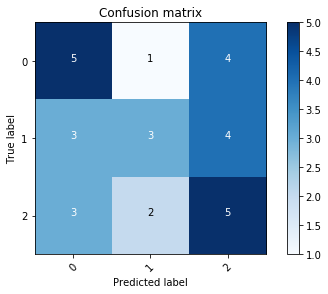

In [20]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3)) 

## LR With Cross Validation

In [21]:
batch_size = 16
nb_classes = 3
nb_epoch = 20

In [32]:
def train_and_evaluate_model(model, x_train, y_train, x_test, y_test):
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                    batch_size=batch_size, epochs=nb_epoch,
                    verbose=1, validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=2)
    return score[1]

In [36]:
n_folds = 10

labels = df['flow_rate'].values
data = x

labels[labels == 1800] = 0
labels[labels == 3600] = 1
labels[labels == 7200] = 2

one_hot = np_utils.to_categorical(labels, nb_classes) 

skf = StratifiedKFold(df['flow_rate'].values, n_folds=n_folds, shuffle=True)
avg_acc = 0

y_true = []
y_pred = []

for i, (train, test) in enumerate(skf):
    print("Running Fold", i+1, "/", n_folds)
    model = None # Clearing the NN.
    model = build_logistic_model(input_dim, nb_classes)
    
    std = np.std(data[train],0)
    mean = np.mean(data[train],0)
    
    x_train = (data[train]-mean)/std
    x_test = (data[test] - mean)/std        
    
    avg_acc += train_and_evaluate_model(model, x_train, one_hot[train], x_test, one_hot[test])
    
    # Predict the values from the validation dataset
    Y_pred = model.predict(x_test)
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(one_hot[test],axis = 1) 
    
    y_true.extend(Y_true)
    y_pred.extend(Y_pred_classes)

Running Fold 1 / 10
[[ 0 12]
 [ 1 12]
 [ 2 12]]
Train on 312 samples, validate on 36 samples
Epoch 1/20
312/312 [==============================] - 1s 4ms/step - loss: 1.4016 - acc: 0.3686 - val_loss: 1.3461 - val_acc: 0.3333
Epoch 2/20
312/312 [==============================] - 0s 272us/step - loss: 1.3527 - acc: 0.3590 - val_loss: 1.2973 - val_acc: 0.3333
Epoch 3/20
312/312 [==============================] - 0s 285us/step - loss: 1.3137 - acc: 0.3526 - val_loss: 1.2513 - val_acc: 0.3333
Epoch 4/20
312/312 [==============================] - 0s 266us/step - loss: 1.2797 - acc: 0.3526 - val_loss: 1.2185 - val_acc: 0.3333
Epoch 5/20
312/312 [==============================] - 0s 295us/step - loss: 1.2518 - acc: 0.3333 - val_loss: 1.1942 - val_acc: 0.3333
Epoch 6/20
312/312 [==============================] - 0s 301us/step - loss: 1.2294 - acc: 0.3397 - val_loss: 1.1750 - val_acc: 0.3333
Epoch 7/20
312/312 [==============================] - 0s 263us/step - loss: 1.2095 - acc: 0.3397 - val_lo

Epoch 20/20
312/312 [==============================] - 0s 259us/step - loss: 1.0435 - acc: 0.4135 - val_loss: 1.1102 - val_acc: 0.3611
Running Fold 4 / 10
[[ 0 12]
 [ 1 12]
 [ 2 12]]
Train on 312 samples, validate on 36 samples
Epoch 1/20
312/312 [==============================] - 1s 5ms/step - loss: 1.4286 - acc: 0.3237 - val_loss: 1.2332 - val_acc: 0.4167
Epoch 2/20
312/312 [==============================] - 0s 272us/step - loss: 1.3571 - acc: 0.3269 - val_loss: 1.1875 - val_acc: 0.4167
Epoch 3/20
312/312 [==============================] - 0s 275us/step - loss: 1.2982 - acc: 0.3365 - val_loss: 1.1534 - val_acc: 0.4167
Epoch 4/20
312/312 [==============================] - 0s 259us/step - loss: 1.2546 - acc: 0.3301 - val_loss: 1.1276 - val_acc: 0.4167
Epoch 5/20
312/312 [==============================] - 0s 272us/step - loss: 1.2200 - acc: 0.3365 - val_loss: 1.1081 - val_acc: 0.4167
Epoch 6/20
312/312 [==============================] - 0s 284us/step - loss: 1.1919 - acc: 0.3269 - val_l

Epoch 19/20
312/312 [==============================] - 0s 295us/step - loss: 1.0888 - acc: 0.3974 - val_loss: 1.1787 - val_acc: 0.3889
Epoch 20/20
312/312 [==============================] - 0s 253us/step - loss: 1.0820 - acc: 0.3974 - val_loss: 1.1733 - val_acc: 0.3889
Running Fold 7 / 10
[[ 0 11]
 [ 1 11]
 [ 2 11]]
Train on 315 samples, validate on 33 samples
Epoch 1/20
315/315 [==============================] - 2s 5ms/step - loss: 1.5292 - acc: 0.3429 - val_loss: 1.4301 - val_acc: 0.3636
Epoch 2/20
315/315 [==============================] - 0s 260us/step - loss: 1.4611 - acc: 0.3238 - val_loss: 1.3733 - val_acc: 0.3636
Epoch 3/20
315/315 [==============================] - 0s 276us/step - loss: 1.4035 - acc: 0.3302 - val_loss: 1.3254 - val_acc: 0.3636
Epoch 4/20
315/315 [==============================] - 0s 244us/step - loss: 1.3559 - acc: 0.3333 - val_loss: 1.2848 - val_acc: 0.3636
Epoch 5/20
315/315 [==============================] - 0s 251us/step - loss: 1.3154 - acc: 0.3333 - val_

Epoch 18/20
315/315 [==============================] - 0s 455us/step - loss: 1.0740 - acc: 0.4349 - val_loss: 1.0737 - val_acc: 0.4242
Epoch 19/20
315/315 [==============================] - 0s 447us/step - loss: 1.0718 - acc: 0.4349 - val_loss: 1.0718 - val_acc: 0.4242
Epoch 20/20
315/315 [==============================] - 0s 476us/step - loss: 1.0694 - acc: 0.4349 - val_loss: 1.0692 - val_acc: 0.3939
Running Fold 10 / 10
[[ 0 11]
 [ 1 11]
 [ 2 11]]
Train on 315 samples, validate on 33 samples
Epoch 1/20
315/315 [==============================] - 2s 7ms/step - loss: 1.6900 - acc: 0.3079 - val_loss: 1.4531 - val_acc: 0.3030
Epoch 2/20
315/315 [==============================] - 0s 320us/step - loss: 1.5861 - acc: 0.3143 - val_loss: 1.3956 - val_acc: 0.3030
Epoch 3/20
315/315 [==============================] - 0s 298us/step - loss: 1.5007 - acc: 0.3048 - val_loss: 1.3479 - val_acc: 0.3030
Epoch 4/20
315/315 [==============================] - 0s 336us/step - loss: 1.4285 - acc: 0.3111 - va

In [37]:
print("Average Accuracy: ", avg_acc/n_folds)

Average Accuracy:  0.3767676767676768


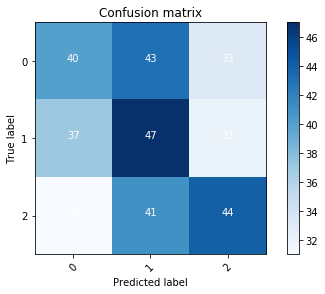

In [38]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(np.array(y_true), np.array(y_pred)) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3)) 